# Imports
## Pip Packages

In [7]:
import os
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from tqdm import tqdm
from random import randint
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)

from src.datasets import FreeViewInMemory, seq2seq_jagged_collate_fn, seq2seq_padded_collate_fn
from src.model import PathModel
from src.cls_metrics import precision,recall,create_cls_targets, accuracy, compute_loss, plt_training_metrics, validate
from src.vis_scanpath import plot_xy_on_image, draw_scanpath


# Training

## Preparing Data

In [2]:
# TODO Separate validation and test sets
datasetv2 = FreeViewInMemory(sample_size= 13,log = True, start_index=2)
total_size = len(datasetv2)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_set, val_set, test_set = random_split(datasetv2, [train_size, val_size, test_size])
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0, collate_fn= seq2seq_padded_collate_fn)
val_dataloader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=0, collate_fn= seq2seq_padded_collate_fn)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=0, collate_fn= seq2seq_padded_collate_fn)

Data loaded in memory


## Creating the model

In [ ]:
# TODO Implement Strategy and Builder pattern

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PathModel(input_dim = 3,
                  output_dim = 3,
                  n_encoder = 2,
                  n_decoder = 2,
                  model_dim = 256,
                  total_dim = 256,
                  n_heads = 4,
                  ff_dim = 512,
                  max_pos_enc=15,
                  max_pos_dec=26,
                  device = device)

## Pipeline

In [ ]:
# Define the optimizer
print('starting model compilation')
model = torch.compile(model) 
optimizer = optim.Adam(model.parameters())
cls_weigth = .5
# Training loop (example with one epoch)
num_epochs = 60 # You can change this to train for more epochs
needs_validate = True
val_interval = 5
reg_loss_list = []
cls_loss_list = []
metrics = {'accuracy': [], 'precision_pos': [], 'recall_pos': [], 'precision_neg': [], 'recall_neg': [], 'epoch': []}
first_time = True
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_reg_loss = 0
    total_cls_loss = 0
    num_batches = 0
    if first_time:
      print('starting data loading')
    for batch in tqdm(train_dataloader):
        x,x_mask,y, y_mask, fixation_len = batch
        x = x.to(device=device)
        y = y.to(device=device)
        if x_mask is not None:
            x_mask = x_mask.to(device = device)
        if y_mask is not None:
            y_mask = y_mask.to(device = device)
        fixation_len = fixation_len.to(device = device)

        optimizer.zero_grad()  # Zero the gradients
        if first_time:
          print('model compilation')
          first_time = False
        reg_out, cls_out = model(x,y, src_mask = x_mask, tgt_mask = y_mask)  # Forward pass
        cls_loss, reg_loss = compute_loss(reg_out,cls_out, y, y_mask, fixation_len) # Compute loss
        total_loss = (1-cls_weigth)*reg_loss + cls_weigth*cls_loss
        total_loss.backward()
        optimizer.step()
        total_reg_loss += reg_loss.item()
        total_cls_loss += cls_loss.item()
        num_batches += 1

    if needs_validate and ((epoch + 1) % val_interval == 0):
        validate(model, val_dataloader, epoch, device, metrics)
      
    avg_reg_loss = total_reg_loss / num_batches
    avg_cls_loss = total_cls_loss / num_batches
    reg_loss_list.append(avg_reg_loss)
    cls_loss_list.append(avg_cls_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Regression Loss: {avg_reg_loss:.4f}, Avg Classification Loss: {avg_cls_loss:.4f}")

print("Training finished!")

100%|██████████| 219/219 [00:52<00:00,  4.21it/s]


Epoch 1/1, Avg Regression Loss: 0.3679, Avg Classification Loss: 43963.0770
Training finished!


# Eval

## Review Metrics

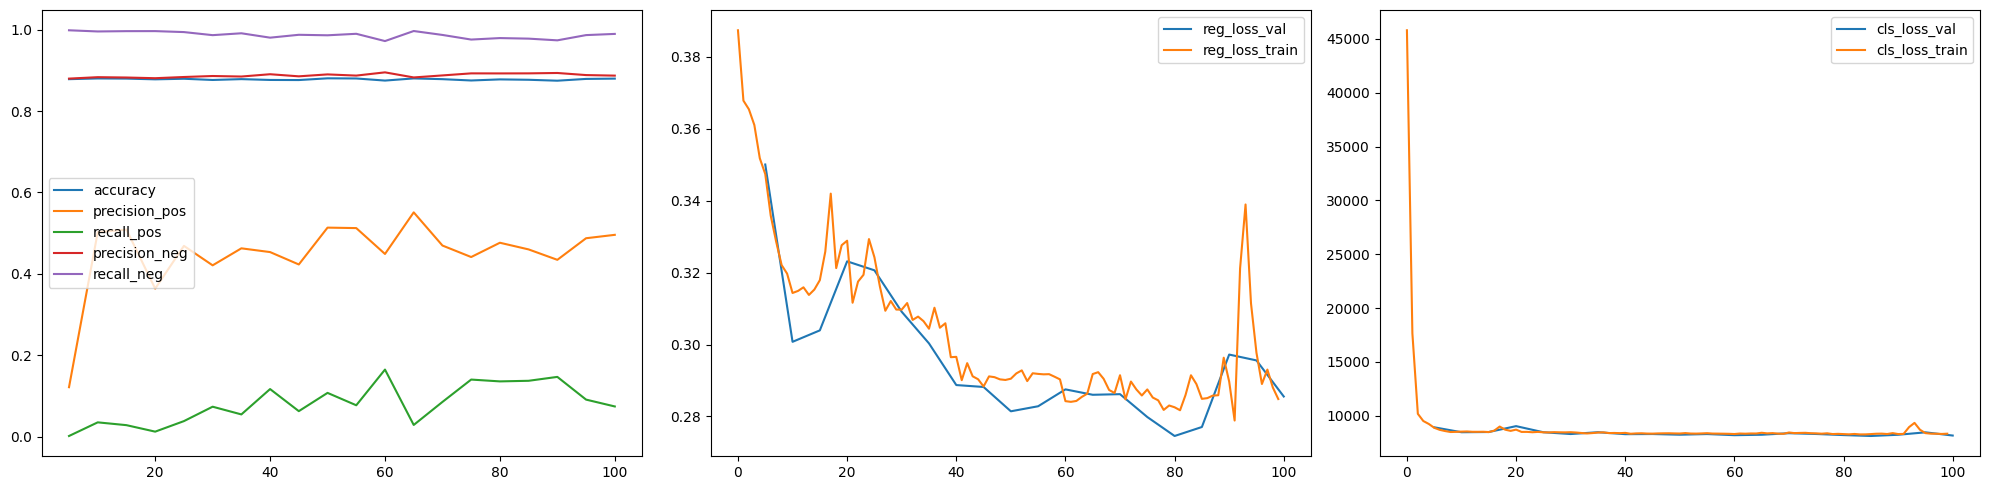

In [ ]:
plt_training_metrics("Output\\metrics\\metrics 100.json")

## Checkout Output

### Load Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PathModel(input_dim = 3,
                  output_dim = 3,
                  n_encoder = 2,
                  n_decoder = 2,
                  model_dim = 256,
                  total_dim = 256,
                  n_heads = 4,
                  ff_dim = 512,
                  max_pos_enc=15,
                  max_pos_dec=26,
                  device = device)

state_dict = torch.load('Output\models\model100.pth', map_location = 'cpu')

# remove the _orig_mod prefix from the state dict keys
new_state_dict = {}
for k, v in state_dict.items():
    # Check if the key starts with the problematic prefix
    if k.startswith('_orig_mod.'):
        # Remove the prefix
        new_key = k[len('_orig_mod.'):]
        new_state_dict[new_key] = v
    else:
        # Keep other keys as they are
        new_state_dict[k] = v

model.load_state_dict(new_state_dict)



<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ulloa\AppData\Local\Temp\ipykernel_20532\841274528.py:14: SyntaxWarning: invalid escape sequence '\m'
  state_dict = torch.load('Output\models\model100.pth', map_location = 'cpu')


<All keys matched successfully>

### Load Batch of data

In [4]:
for batch in tqdm(train_dataloader):
        x,x_mask,y, y_mask, fixation_len = batch
        x = x.to(device=device)
        y = y.to(device=device)
        if x_mask is not None:
            x_mask = x_mask.to(device = device)
        if y_mask is not None:
            y_mask = y_mask.to(device = device)
        fixation_len = fixation_len.to(device = device)
        break

  0%|          | 0/219 [00:03<?, ?it/s]


### Eval

In [5]:
with torch.no_grad():
    reg_out,cls_out = model(x,y, x_mask, y_mask)
    cls_targets = create_cls_targets(cls_out, fixation_len)
    print('accuracy: ',accuracy(cls_out, y_mask, cls_targets))
    print('precision_pos: ',precision(cls_out, y_mask, cls_targets))
    print('recall_pos: ',recall(cls_out, y_mask, cls_targets))
    print('precision_neg: ',precision(cls_out, y_mask, cls_targets, cls = 0))
    print('recall_neg: ',recall(cls_out, y_mask, cls_targets, cls = 0))

accuracy:  0.8776908023483366
precision_pos:  0.6363636363636364
recall_pos:  0.0546875
precision_neg:  0.8803165182987142
recall_neg:  0.9955257270693513


In [31]:
def get_coords(idx, x,y, reg_out):
    x_coords = x[idx,:,:2].cpu().numpy().T
    y_coords = y[idx,:fixation_len[idx],:2].cpu().numpy().T
    reg_coords = reg_out[idx,:fixation_len[idx],:2].cpu().numpy().T
    x_coords = x_coords[:,::-1]
    y_coords = y_coords[:,::-1]
    reg_coords = reg_coords[:,::-1]
    return x_coords, y_coords, reg_coords

tensor(9)


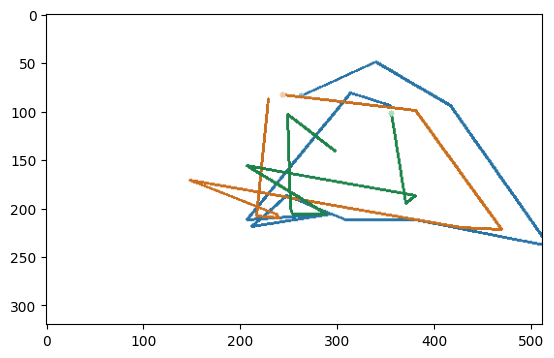

In [ ]:
idx = randint(0,128-1)
x_coords, y_coords, reg_coords = get_coords(idx, x, y, reg_out)
img = np.ones((320,512,3),dtype=np.uint8)*255

traj = [x_coords,
        y_coords, 
        reg_coords]
traj_colors = [(40, 116, 166), # blue
               (202, 111, 30), # orange
               (29, 131, 72)] # green

end_point_colors = [(133, 193, 233),
                    (245, 203, 167),
                    (169, 223, 191)]

for traj, color, end_color in zip(traj, traj_colors, end_point_colors):
    img = draw_scanpath(img, traj[0],traj[1], color=color, end_color=end_color)

print(fixation_len[idx])

plt.imshow(img)
plt.show()
